# Predicting whether given passengers would survive the Titanic disaster

Given a set of training data that tells us whether or not certain passengers survived, can we predict whether a given person not in the training set will survive based on their gender, age, ticket class, etc?


## Setup - import all methods I will need

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Import Data

In [2]:
train_df = pd.read_csv('/Users/blairkirkpatrick/Documents/python/titanic_kaggle/data/train.csv')
test_df = pd.read_csv('/Users/blairkirkpatrick/Documents/python/titanic_kaggle/data/test.csv')
combine = [train_df, test_df] # it will be useful to combine data for easier processing.

In [4]:
print(train_df.columns.values) # give an overview of what features we have to work with.

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Here the following features are categorical: {'Survived', 'Pclass', 'Sex', 'Embarked'},
                                  and numerical: {'Age', 'Fare', 'SibSp', 'Parch'}

In [6]:
# preview data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Comments on data features

We note here that 'Ticket' and 'Cabin' use mixed data types i.e. alphanumeric and numerical. They will likely be candidates for features that need to be cleaned.

The 'Name' feature is probably the most likely to contain typos as there are many alternative ways to write the same information.

{'Cabin', 'Age', 'Embarked'} contain null values in the training data set while 
{'Cabin', 'Age'} are incomplete in the test data set.

Expect to have 7 features represented as integers or floats, and 5 features represented as strings.

In [7]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [8]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).

Around 38% samples survived representative of the actual survival rate at 32%.

Most passengers (> 75%) did not travel with parents or children.

Nearly 30% of the passengers had siblings and/or spouse aboard.

Fares varied significantly with few passengers (<1%) paying as high as $512.

Few elderly passengers (<1%) within age range 65-80.

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sivola, Mr. Antti Wilhelm",male,CA. 2343,G6,S
freq,1,577,7,4,644


Names are unique across the dataset (count=unique=891)

Sex variable as two possible values with 65% male (top=male, freq=577/count=891).

Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.

Embarked takes three possible values. S port used by most passengers (top=S).

Ticket feature has high ratio (22%) of duplicate values (unique=681).

# What are my assumptions about the data at this point?

## Correlating
How well does each feature correlate to survival? Figure this out early and then match these broad correlations with correlations found later in the modelling part of our project.

## Completing
1. We need to complete the 'Age' feature as it will definitely be correlated to survival.
2. We may want to complete the 'Emabrked' feature as it might correlate to survival too.

## Correcting
1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so may be dropped.

## Ceating
1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

## Classifying
We may also add to our assumptions based on the problem description noted earlier.
1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived.
3. The upper-class passengers (Pclass=1) were more likely to have survived.

# Feature Pivoting - Quick Analysis

In [15]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# Pclass - We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). 
# We decide to include this feature in our model.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [16]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# Sex - We confirm the observation during problem definition that Sex=female had very high survival rate at 74%.

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# SibSp - Zero correlation for certain values. 
# It may be best to derive a feature or a set of features from these individual features (creating #1).

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [18]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# Parch - Zero correlation for certain values. 
# It may be best to derive a feature or a set of features from these individual features (creating #1).

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Data Visualisation - Quick Analysis

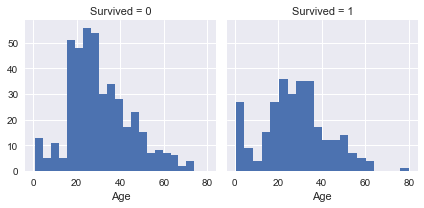

In [22]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## Observations.

Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.

## Decisions.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

We should consider Age (our assumption classifying #2) in our model training.
Complete the Age feature for null values (completing #1).
We should band age groups (creating #3).

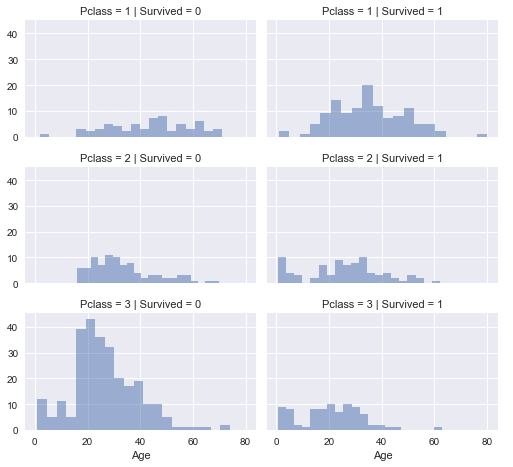

In [23]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## Observations.

Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
Pclass varies in terms of Age distribution of passengers.

## Decisions.

Consider Pclass for model training.

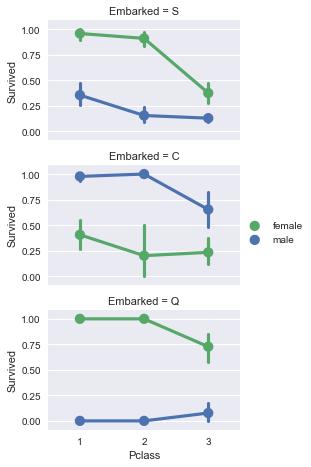

In [24]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Observations.

Female passengers had much better survival rate than males. Confirms classifying (#1).
Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

## Decisions.

Add Sex feature to model training.
Complete and add Embarked feature to model training.

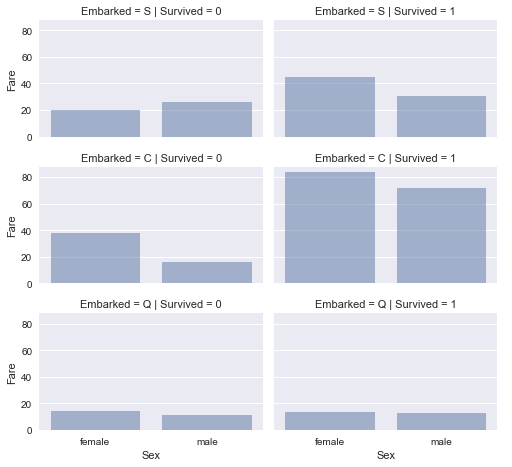

In [25]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Observations.

Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

## Decisions.

Consider banding Fare feature.

# Data Wrangling